In [3]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
import random

# Check TensorFlow version
print("Tensorflow version " + tf.__version__)

# Try to detect TPUs
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

# Setup distribution strategy based on available devices (TPU or GPU or CPU)
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Path configurations
GCS_DS_PATH = '/kaggle/input/tpu-getting-started'
IMAGE_SIZE = [224, 224]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-224x224'
AUTO = tf.data.experimental.AUTOTUNE

# Function to count the number of images in each set of TFRecord files
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Create datasets
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# Load dataset filenames
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

# Count the total number of images in each set
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

# Modify the steps per epoch and validation steps for the dataset
steps_per_epoch = NUM_TRAINING_IMAGES // BATCH_SIZE if NUM_TRAINING_IMAGES // BATCH_SIZE > 0 else 1
validation_steps = NUM_VALIDATION_IMAGES // BATCH_SIZE if NUM_VALIDATION_IMAGES // BATCH_SIZE > 0 else 1
print('Dataset: {} training images, {} validation images, {} testing images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

# Read and parse the datasets
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_training_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

training_dataset = get_training_dataset(TRAINING_FILENAMES)
validation_dataset = get_validation_dataset(VALIDATION_FILENAMES)

print("Training and validation datasets loaded successfully!")


Tensorflow version 2.12.0
REPLICAS:  1
Dataset: 12753 training images, 3712 validation images, 7382 testing images
Training and validation datasets loaded successfully!


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Set a seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)

# Function to build a CNN model based on provided parameters
def create_model(n_layers, neurons_per_layer, kernel_size):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)))
    
    # Add Conv2D and MaxPooling2D layers based on the number of layers specified
    for i in range(n_layers):
        model.add(layers.Conv2D(neurons_per_layer[i], kernel_size, activation='relu', padding='same'))
        model.add(layers.MaxPooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(104, activation='softmax')) # There are 104 types of flowers
    
    return model

# Hyperparameters to experiment with
layer_options = [2, 3, 4]
neuron_options = [[32, 64], [32, 64, 128], [32, 64, 128, 256]]
kernel_sizes = [(3,3), (5,5)]

# Placeholder for recording performances
performances = {}

# Ensuring we're using the distribution strategy scope
with strategy.scope():
    for n_layers, neurons in zip(layer_options, neuron_options):
        for kernel_size in kernel_sizes:
            # Build model
            model = create_model(n_layers, neurons, kernel_size)
            
            # Compile the model
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            
            # Train the model (For demonstration, we are training for just a few epochs. You should train longer.)
            history = model.fit(training_dataset, epochs=5, steps_per_epoch=steps_per_epoch,
                                validation_data=validation_dataset, validation_steps=validation_steps)
            
            # Record performance
            key = f"{n_layers}_layers_{neurons}_neurons_{kernel_size}_kernel"
            performances[key] = history.history['val_accuracy'][-1]

# Display the performances
for key, val in performances.items():
    print(f"{key}: {val:.4f} accuracy")

# You can further visualize the performances using a bar chart, as mentioned in the instructions.

Epoch 1/5
398/398 [==============================] - 744s 2s/step - loss: 22.1152 - accuracy: 0.0753 - val_loss: 4.4537 - val_accuracy: 0.0819
Epoch 2/5
398/398 [==============================] - 733s 2s/step - loss: 3.3074 - accuracy: 0.2468 - val_loss: 5.9075 - val_accuracy: 0.0889
Epoch 3/5
398/398 [==============================] - 740s 2s/step - loss: 2.1436 - accuracy: 0.4933 - val_loss: 7.7582 - val_accuracy: 0.0803
Epoch 4/5
398/398 [==============================] - 734s 2s/step - loss: 1.3838 - accuracy: 0.6627 - val_loss: 12.2672 - val_accuracy: 0.0779
Epoch 5/5
398/398 [==============================] - 735s 2s/step - loss: 0.8701 - accuracy: 0.7857 - val_loss: 14.5806 - val_accuracy: 0.0776
Epoch 1/5
398/398 [==============================] - 1290s 3s/step - loss: 10.8975 - accuracy: 0.0599 - val_loss: 4.2062 - val_accuracy: 0.0606
Epoch 2/5
398/398 [==============================] - 1296s 3s/step - loss: 3.9228 - accuracy: 0.1068 - val_loss: 4.9500 - val_accuracy: 0.0609


2_layers_[32, 64]_neurons_(3, 3)_kernel: 0.0776 accuracy
2_layers_[32, 64]_neurons_(5, 5)_kernel: 0.0539 accuracy
3_layers_[32, 64, 128]_neurons_(3, 3)_kernel: 0.1067 accuracy
3_layers_[32, 64, 128]_neurons_(5, 5)_kernel: 0.1323 accuracy
4_layers_[32, 64, 128, 256]_neurons_(3, 3)_kernel: 0.1802 accuracy
4_layers_[32, 64, 128, 256]_neurons_(5, 5)_kernel: 0.2050 accuracy


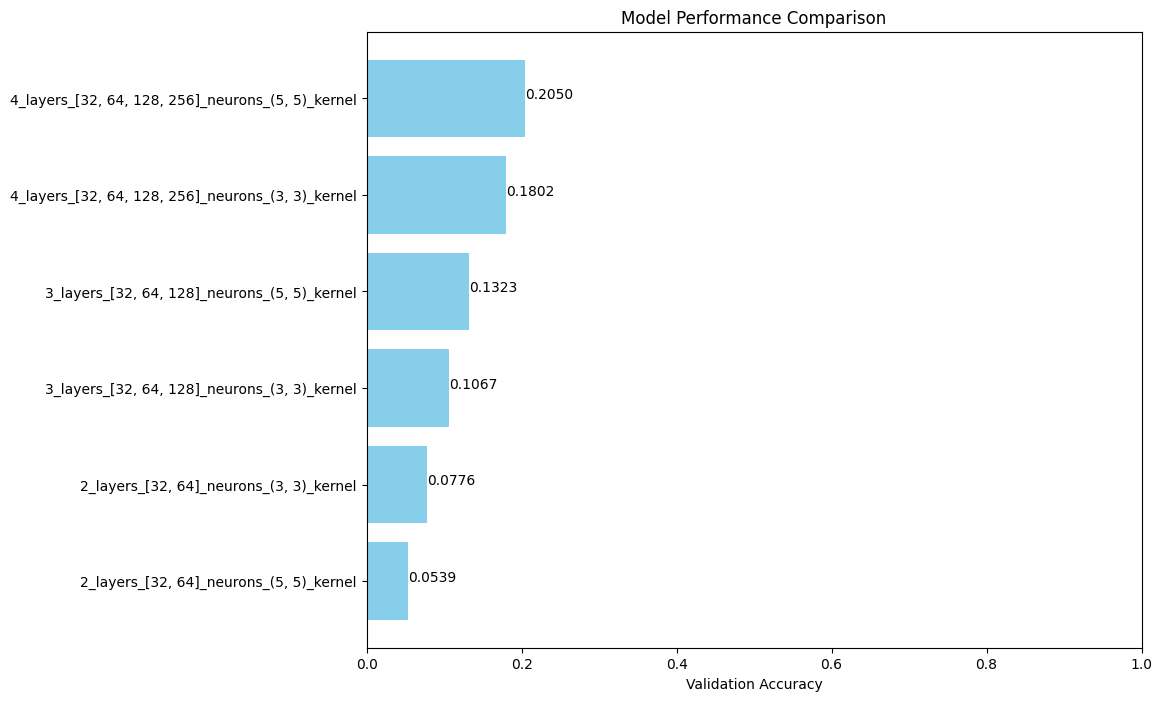

In [7]:
import matplotlib.pyplot as plt
# Display the performances
for key, val in performances.items():
    print(f"{key}: {val:.4f} accuracy")

# Visualize the performances using a bar chart
# Sort performances for better visual representation
sorted_keys = sorted(performances.keys(), key=lambda x: performances[x])

# Data for plotting
labels = sorted_keys
accuracy = [performances[key] for key in sorted_keys]

# Plotting the bar chart
plt.figure(figsize=(10, 8))
plt.barh(labels, accuracy, color='skyblue')
plt.xlabel('Validation Accuracy')
plt.title('Model Performance Comparison')
plt.xlim(0, 1)  # Assuming accuracy ranges from 0 to 1
for index, value in enumerate(accuracy):
    plt.text(value, index, f'{value:.4f}')

plt.show()
